<a href="https://colab.research.google.com/github/thiagolermen/facemask-detection-v1/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Mask Detection

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing mask or not wearing them..
This dataset contains 3811 images belonging to the 2 classes.
The classes are:

- With mask;
- Without mask;


##Import

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from keras.preprocessing.image import *
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

###Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Path to Kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/facemask-detection
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle/facemask-detection


##Dataset

In [5]:
# Checking the file
!ls

haarcascade_frontalface_default.xml  with3.jpeg  without1.jpg  without6.jpg
rose1.jpg			     with4.jpg	 without2.jpg  without_mask
rose2.jpg			     with5.jpg	 without3.jpg  X_train.pickle
with1.jpg			     with6.jpg	 without4.jpg  y_train.pickle
with2.jpg			     with_mask	 without5.jpg


In [6]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [27]:
import pathlib
# Root directory
dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/"


In [31]:
# Train data
train_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/train/"
train_with_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/train/with_mask/"
train_with_dir = pathlib.Path(train_with_dir)
train_without_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/train/without_mask/"
train_without_dir = pathlib.Path(train_without_dir)

classes = ["with_mask", "without_mask"]

In [32]:
test_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/test/"
test_with_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/test/with_mask/"
test_with_dir = pathlib.Path(test_with_dir)
test_without_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/test/without_mask/"
test_without_dir = pathlib.Path(test_without_dir)

Counting the number of files

In [34]:
mask_count_train = len(list(train_with_dir.glob('*.*')))
no_mask_count_train = len(list(train_without_dir.glob('*.*')))
mask_count_test = len(list(test_with_dir.glob('*.*')))
no_mask_count_test = len(list(test_without_dir.glob('*.*')))
print("Number of images in the training set:")
print(f"Number of images with mask: {mask_count_train} \nNumber of images without mask: {no_mask_count_train} \n")
print("Number of images in the test set:")
print(f"Number of images with mask: {mask_count_test} \nNumber of images without mask: {no_mask_count_test} \n")
print(f"Total number of images: {mask_count_train+no_mask_count_train+mask_count_test+no_mask_count_test}")


Number of images in the training set:
Number of images with mask: 1741 
Number of images without mask: 1781 

Number of images in the test set:
Number of images with mask: 150 
Number of images without mask: 139 

Total number of images: 3811


In [48]:
# Creating the number of categories

classes = ["with_mask", "without_mask"]

###Visualizing the dataset

In [77]:
def visualize_data(dir):
  plt.figure(figsize = (20 , 20))
  i=0
  count = 0
  for category in classes:
    path = os.path.join(dir, category)
    j=0
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      plt.subplot(3, 3, count+1)
      plt.title(category)
      plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
      plt.show
      j = j+1
      count = count+1
      if j == 3:
        break
    i = i+1
    if i == 3:
      break

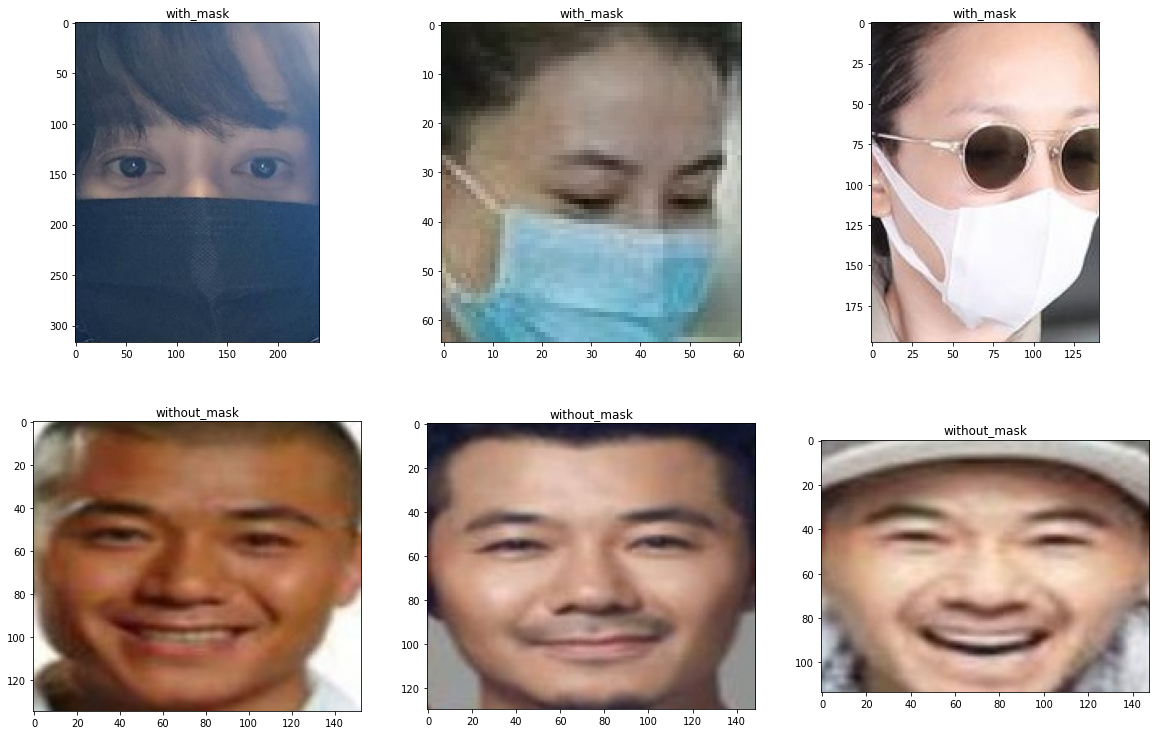

In [78]:
visualize_data(train_dir)

###Preprocessing data

We need to preprocess all the images. First of all we need to set a default image size (=224). We're going to use this size to match with the pretrained model which input is an image size (224,224,3)

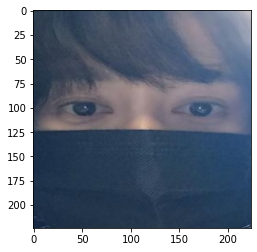

In [50]:
# Example with one image
img_size = 224
img = os.listdir(train_with_dir)[0]
img_array = cv2.imread(os.path.join(train_with_dir, img))
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))

####Augmentation

In [52]:
# Generate augmented data
datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip  = True,
    rotation_range = 40,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

# For the training set
train_generator = datagen.flow_from_directory(
    train_dir,
    batch_size = 32,
    class_mode = 'binary',
    target_size = (224, 224)
)

# For the test set
test_generator = datagen.flow_from_directory(
    test_dir,
    batch_size = 32,
    class_mode = 'binary',
    target_size = (224, 224)
)

# For the cross validation set
valid_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size = 32,
    class_mode = 'binary',
    target_size = (224, 224)
)

Found 3522 images belonging to 2 classes.
Found 289 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [59]:
print(f"Training data (batched) size: {len(train_generator)}")
print(f"Test data (batched) size: {len(test_generator)}")
print(f"CV data (batched) size: {len(valid_generator)}")

Training data (batched) size: 111
Test data (batched) size: 10
CV data (batched) size: 10


##Creating the model

Pretrained model:

In [269]:
model = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
model.summary()

####Fine tuning

In [271]:
base_input = model.layers[0].input # the model starts at the pretrained model's first layer

In [272]:
base_output = model.layers[-4].output # cuts at the pretraining model's dropout layer

In [273]:
flatten_layer = layers.Flatten()(base_input) # connect this layer with base_input
final_output = layers.Dense(1)(flatten_layer) # connect with flatten_layer
                                              # the model classifies in 1 or 0 (with or without mask)
final_output = layers.Activation('sigmoid')(final_output) # add an activation function to the dense layer

In [274]:
new_model = keras.Model(inputs = base_input, outputs=final_output)

In [275]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 150529    
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


##Compile the model

In [285]:
new_model.compile(loss = "binary_crossentropy", 
                  optimizer="adam",
                  metrics = ["accuracy"])

##Training the model

In [286]:
epochs = 30
history = new_model.fit(
    train_generator,
    batch_size = 32,
    epochs = epochs,
    validation_data = test_generator,
)

Epoch 1/30
 35/111 [========>.....................] - ETA: 41s - loss: 11.4089 - accuracy: 0.5216

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


111/111 [==============================] - 66s 588ms/step - loss: 6.8615 - accuracy: 0.6157 - val_loss: 1.1434 - val_accuracy: 0.7716
Epoch 2/30
111/111 [==============================] - 65s 587ms/step - loss: 0.9556 - accuracy: 0.8235 - val_loss: 0.5278 - val_accuracy: 0.8789
Epoch 3/30
111/111 [==============================] - 65s 585ms/step - loss: 0.7215 - accuracy: 0.8664 - val_loss: 2.7183 - val_accuracy: 0.6228
Epoch 4/30
111/111 [==============================] - 65s 581ms/step - loss: 2.4264 - accuracy: 0.7575 - val_loss: 0.6679 - val_accuracy: 0.9100
Epoch 5/30
111/111 [==============================] - 65s 583ms/step - loss: 1.1737 - accuracy: 0.8426 - val_loss: 0.4168 - val_accuracy: 0.9239
Epoch 6/30
111/111 [==============================] - 64s 578ms/step - loss: 1.2639 - accuracy: 0.8481 - val_loss: 1.7319 - val_accuracy: 0.7820
Epoch 7/30
111/111 [==============================] - 64s 581ms/step - loss: 1.6440 - accuracy: 0.8167 - val_loss: 1.1552 - val_accuracy: 0.8

No handles with labels found to put in legend.
No handles with labels found to put in legend.


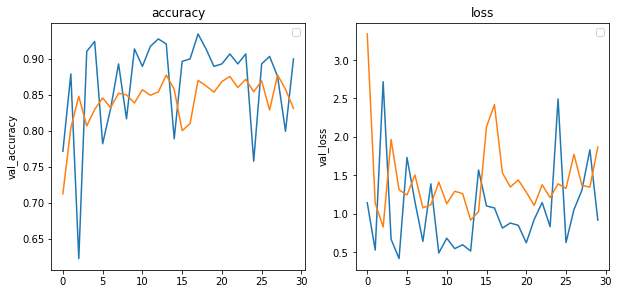

In [287]:
plt.figure(figsize = (10, 10))

plt.subplot(2,2, 3)
plt.title('accuracy')
sns.lineplot(data = history.history, x = range(len(history.history['val_accuracy'])), y = 'val_accuracy')
sns.lineplot(data = history.history, x = range(len(history.history['val_accuracy'])), y = 'accuracy')
plt.legend()

plt.subplot(2,2, 4)
plt.title('loss')
sns.lineplot(data = history.history, x = range(len(history.history['val_accuracy'])), y = 'val_loss')
sns.lineplot(data = history.history, x = range(len(history.history['val_accuracy'])), y = 'loss')
plt.legend()

##Predictions

We're going to use [Haar Cascade Face Detection](https://github.com/opencv/opencv/tree/master/data/haarcascades) by OpenCV

In [314]:
path = '/content/gdrive/My Drive/Kaggle/facemask-detection/test/with_mask/with1.jpg'
image = cv2.imread(path)

In [315]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

error: ignored

In [290]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [291]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [292]:
faces = faceCascade.detectMultiScale(image_gray, 1.1, 4)
for x,y,w,h in faces:
  only_face_gray = image_gray[y:y+h, x:x+w]
  only_face = image[y:y+h, x:x+w]
  cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,255), 2)
  facess = faceCascade.detectMultiScale(only_face_gray)
  if len(facess) == 0:
    print("Face not detected!")
  else:
    for (ex,ey,ew,eh) in facess:
      cropped_face = only_face[ey:ey+eh, ex:ex+ew]

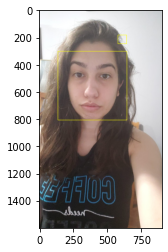

In [293]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

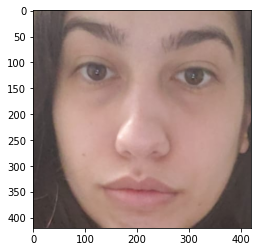

In [294]:
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))

In [295]:
final_image = cv2.resize(cropped_face, (224,224))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [296]:
prediction = new_model.predict(final_image)

In [297]:
if prediction[0][0] > 0.5:
  print("With mask")
else:
  print("Without mask")

Without mask


In [365]:
def face_detection(path):
  image = cv2.imread(path)
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(image_gray, 1.1, 4)
  for x,y,w,h in faces:
    only_face_gray = image_gray[y:y+h, x:x+w]
    only_face = image[y:y+h, x:x+w]
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,255), 2)
    facess = faceCascade.detectMultiScale(only_face_gray)
    if len(facess) == 0:
      print("Face not detected!")
    else:
      for (ex,ey,ew,eh) in facess:
        cropped_face = only_face[ey:ey+eh, ex:ex+ew]

        final_image = cv2.resize(cropped_face, (224,224))
        final_image = np.expand_dims(final_image, axis=0)
        final_image = final_image/255.0

        prediction = new_model.predict(final_image)
        if prediction[0][0] > 0.5:
          print("With mask")
          text = "MASK"
        else:
          print("Without mask")
          text = "NO MASK"
        
        # Plot two images
        font = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(cropped_face, text, (ex+10, ey+10), font, (2*ex)/ey, color=(0, 255, 255), thickness=1)

        plt.figure(figsize = (10,10))

        plt.subplot(1,2,1)
        plt.title('Full image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        plt.subplot(1,2,2)
        plt.title('face_only')
        plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))


With mask


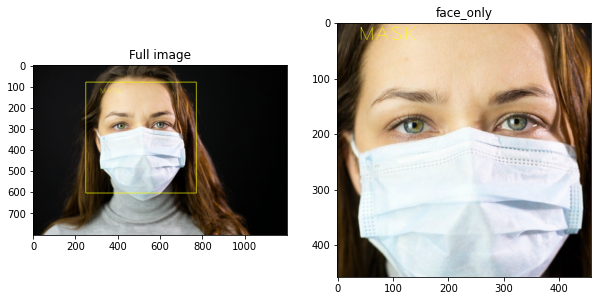

In [367]:
face_detection('/content/gdrive/My Drive/Kaggle/facemask-detection/test/with_mask/with2.jpg')

With mask


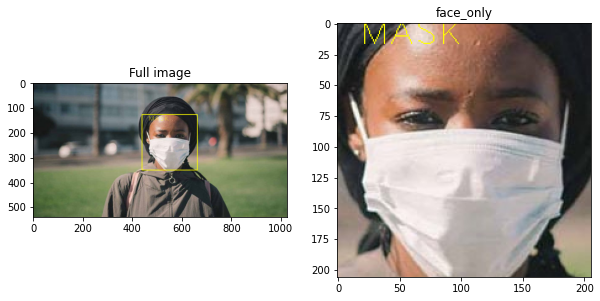

In [368]:
face_detection('/content/gdrive/My Drive/Kaggle/facemask-detection/test/with_mask/with6.jpg')

Face not detected!
With mask
Without mask


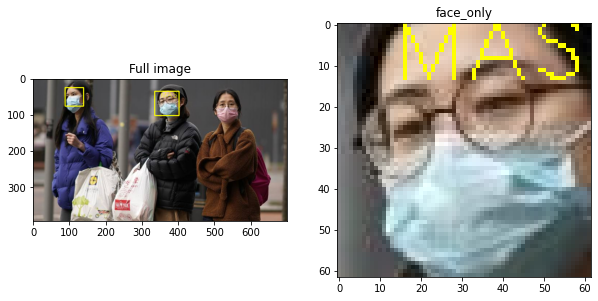

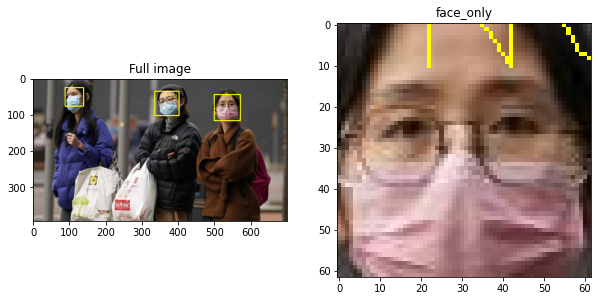

In [369]:
face_detection('/content/gdrive/My Drive/Kaggle/facemask-detection/test/test1.jpg')

With mask


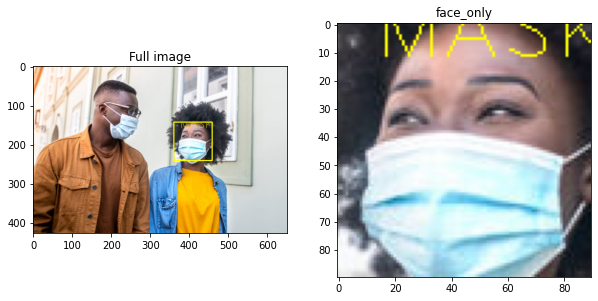

In [370]:
face_detection('/content/gdrive/My Drive/Kaggle/facemask-detection/test/test2.jpg')

Without mask
Without mask
Face not detected!
With mask
Without mask
Without mask
With mask
Without mask
Without mask
With mask
Without mask
Without mask
Without mask


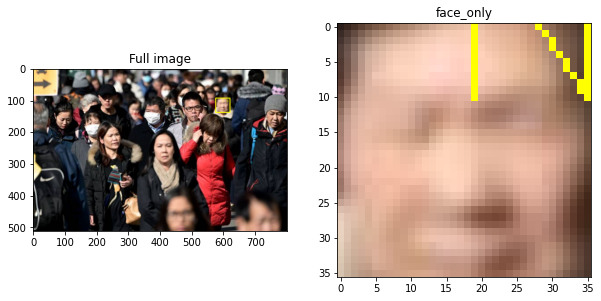

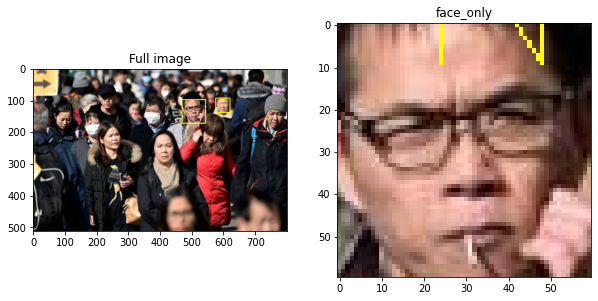

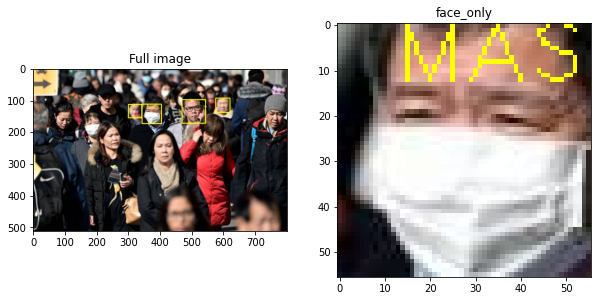

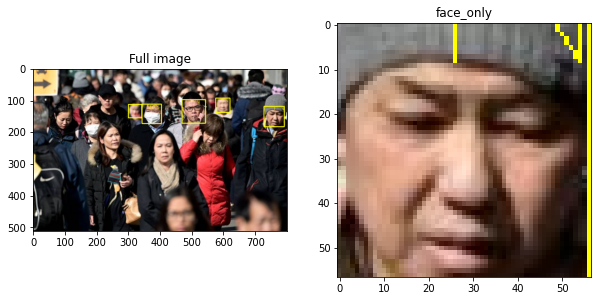

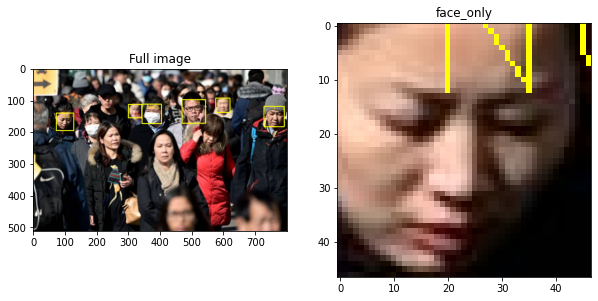

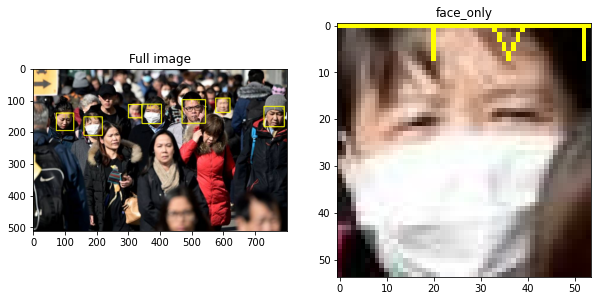

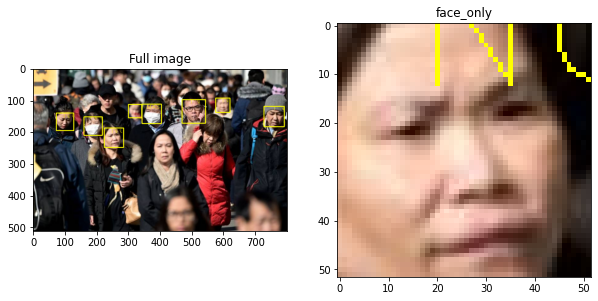

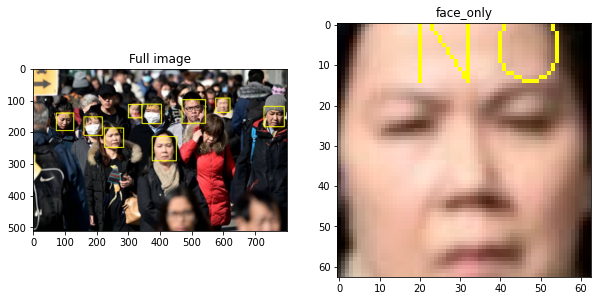

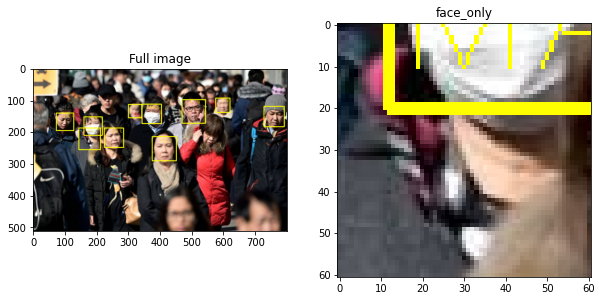

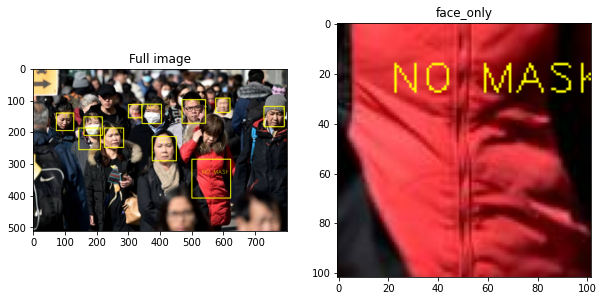

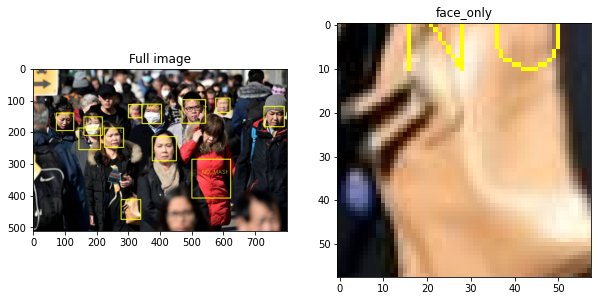

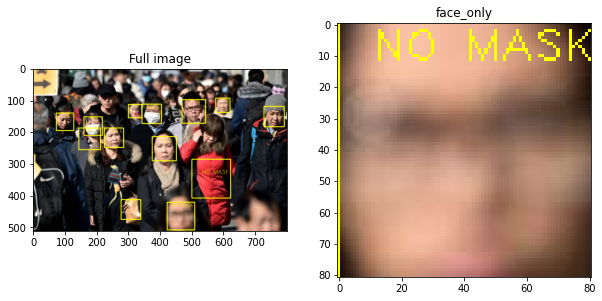

In [371]:
face_detection('/content/gdrive/My Drive/Kaggle/facemask-detection/test/test3.jpg')